Importing the relevant libraries and functions:

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from numpy import nan as NA
%matplotlib inline 

import requests
import os
import time
from tqdm.notebook import tqdm
import scraping_class
from webdriver_manager.chrome import ChromeDriverManager
import requests
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.proxy import Proxy, ProxyType
from selenium.common.exceptions import TimeoutException, WebDriverException,ElementNotVisibleException
from random_user_agent.user_agent import UserAgent 
from random_user_agent.params import SoftwareName, OperatingSystem 
from time import sleep
import logging
import traceback
from self import self

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error as mse

# Section 1: Scraping

## Step 1: Scraping the search page 

#### Selenium request

The Vivino page has a search page, with opportunity to filter on different variables. We chose to filter on red wines from Italy and the price was set to be 0-2500+. This gave us 99 841 wines, and we were far from collecting information on them all, since scrolling usually stopped after 3000 wines, and it was time consuming. 
The page had to either be sorted by ratings, price, discount or popularity.
So we did it over several links, where we changed the way they were sorted by, to get wines from various price and rating. 

In [16]:
start_time = time.time()

url = 'https://www.vivino.com/explore?e=eJwNijEOgCAQBH-zNZpYXmfHE4wxJyK5RMDABfX30swUM7HQgCiJDCK_NE7GwH00W7gOi7vncFLjIl75Qt6psEoKdePmCwePTIevDo8ua5_dV7tFfwGHHeQ='
# Setting up chromedriver
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get(url)

time.sleep(1)

SCROLL_PAUSE_TIME = 10

# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

# Parsed to a soup
soup = BeautifulSoup(driver.page_source, 'lxml')

print("--- %s seconds ---" % round((time.time() - start_time),2))

[WDM] - Current google-chrome version is 84.0.4147
[WDM] - Get LATEST driver version for 84.0.4147
[WDM] - Driver [/Users/lilly/.wdm/drivers/chromedriver/mac64/84.0.4147.30/chromedriver] found in cache


 
--- 4378.06 seconds ---


#### Extracting from soup

In [107]:
# Finding the needed information in the soup and makes a dataframe

soup_select = soup.find_all('div', {'class': 'explorerCard__explorerCard--3Q7_0 explorerPageResults__explorerCard--3q6Qe'})
vivino = 'https://www.vivino.com'
urls = []
names = []
ratings = []
region = []

for i in soup_select:
    # find all a tags -connoting a hyperlink.
    links = i.find_all('a', {'class': 'anchor__anchor--2QZvA'}) 
    #  Save the links constructed in the urls list
    urls.append([vivino+link['href'] for link in links if link.has_attr('href')][0])
    # Saving wine titles in names
    names.append(i.find_all('span', {'class': 'vintageTitle__wine--U7t9G'})[0].text)
    # Saving total rating in ratings
    ratings.append(i.find_all('div', {'class': 'vivinoRatingWide__averageValue--1zL_5'})[0].text)
    # Saving region of the wine
    region.append(i.find_all('a', {'class': 'anchor__anchor--2QZvA vintageLocation__anchor--T7J3k'})[2].text)

'''The list are zipped and saved to a dataframe for later use. We applied drop_duplicates by link
to avoid having to have two of the same wines in our dataset. The dataframe is then saved if needed.'''

df = pd.DataFrame(zip(names,ratings,region,urls), columns=['name','rating','region','link'])
vivino = df.drop_duplicates().reset_index(drop=True)
#vivino.to_csv('vivino_random.csv')

vivino

,name,rating,region,link
0,Toscana 2008,4.7,Toscana,https://www.vivino.com/masseto-toscana/w/24467...
1,Toscana 2006,4.8,Toscana,https://www.vivino.com/masseto-toscana/w/24467...
2,Toscana 2015,4.7,Toscana,https://www.vivino.com/masseto-toscana/w/24467...
3,Toscana 2009,4.7,Toscana,https://www.vivino.com/masseto-toscana/w/24467...
4,Toscana 2007,4.7,Toscana,https://www.vivino.com/masseto-toscana/w/24467...
...,...,...,...,...
1932,Farnito Cabernet Sauvignon Toscana 2010,4.0,Toscana,https://www.vivino.com/carpineto-farnito-caber...
1933,Morellino di Scansano 2017,3.6,Morellino di Scansano,https://www.vivino.com/fattoria-le-pupille-mor...
1934,Barbera d'Alba 2016,3.8,Barbera d'Alba,https://www.vivino.com/pio-cesare-barbera-d-al...
1935,Bricco Ambrogio Barolo 2014,4.2,Barolo,https://www.vivino.com/lodali-barolo-bricco-am...


In [ ]:
# Optionally: if two dataframes have to be merged to create a big dataframe

#Load the other dataframe/dataframes
df_loaded = pd.read_csv('Insert file name.csv', index_col=[0])

# Merging two dataframes
merged = pd.concat([df_loaded,vivino])

#drop duplicates and reset index 
df3 = merged.drop_duplicates().reset_index(drop=True)

# Save the merged dataframe 
df3.to_csv('Insert filename of your choice.csv')

## Step 2: Scraping each link

### Collecting data with selenium
In this part we need to call different libraries, most importantly selenium and random_user_agent.

We started a class called request in which the function get_selenium_res is defined. The function utilizes the random_user_agent module imported to automatically procure a random user agent for each selenium call we make. From there on we altered some chrome options, such as to go ”— headless”, which means that the chrome browser won’t physically open on our machines, the reason for that is to reduce the load on the machine’s cpu and to be able to loop over more  than one URL. Another option which had to be altered is “— window-size”; The window size must be stretched, since selenium only will return the domain that it was required to load.  
   When opening a browser, we use WebDriverWait with a time frame of 90 seconds in which chrome will not close or return the html before a particular element is rendered. The element we chose has the specified particular class 'indicatorBar__progress--3aXLX', this will give us the information on the different taste profiles, later on the process, we discovered there were a few pages without this class name, so it had to be changed to 'vivinoRatingWide__averageValue--1zL_5'. The function will return the html of the page if succeeded, if not either a Timeout Exception or a WebDriverException will occur. In case of an exception; We return the same get_selenium_res function, since we would like to automatically retry. 


In [266]:
class Request:
    
    # These are used to keep track of progress in the log 
    selenium_retries = 0
    nr = 1
    
    # Configuring a new file to save the log
    logging.basicConfig(filename = "TheScraping.log",
                        format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                        filemode = 'w')
    #Creating af logger object, in order to reference to the same logger object
    logger = logging.getLogger('wine_project.requests')
    
    # Setting the logging level to info
    logger.setLevel(logging.INFO) 
  
    def __init__(self,url):
        self.url = url
   
    def get_selenium_res(self,class_name):
        # Keeping track of how many requests has been made to the same URL
        self.logger.info('sending request #: '+str(self.nr)+' to '+str(self.url))
        self.nr += 1
        
        try:
            # This part is to generate various user agents
            software_names = [SoftwareName.CHROME.value]
            operating_systems = [OperatingSystem.WINDOWS.value,
                                  OperatingSystem.LINUX.value]
            user_agent_rotator = UserAgent(software_names=software_names,
                                            operating_systems=operating_systems,
                                            limit=100)
            user_agent = user_agent_rotator.get_random_user_agent()
             
            # Options for chrome is defines    
            chrome_options = Options()
            chrome_options.add_argument("--headless") # Chrome won't open a browser everytime
            chrome_options.add_argument("--no-sandbox") # The only way to get chrome to open headlessly  
            chrome_options.add_argument("--window-size=1420,1080") # Stretching the window size
            chrome_options.add_argument(f'user-agent={user_agent}') # Inserting a random user-agent 
            
            # Setting driver with the specific options and pathway to the chromedriver
            # nb: Change the pathway to chromedriver 
    
            browser = webdriver.Chrome('/Users/lilly/Desktop/chromedriver',options=chrome_options)
            
            # Sending request for the html
            browser.get(self.url)
             
            '''Webdriverwait sets a time frame for the page to load, chrome won't return the dom 
                until class_name variable is retrieved'''
            time_to_wait = 90    
            WebDriverWait(browser,time_to_wait).until(
                EC.presence_of_element_located((By.CLASS_NAME, class_name)))
            
        '''If selenium request wasn’t able to obtain any response in the time frame set up, 
            it's a sign of getting blocked, and it will raise a TimeoutException, in case of an
            exception we simply return the same get_selenium_res function'''
        
        except(TimeoutException,WebDriverException):
            # Logging the error and counting selenium retries 
            self.logger.error(traceback.format_exc())
            self.selenium_retries += 1
            self.logger.info('Selenium retry #: '+ str(self.selenium_retries))
            return self.get_selenium_res(class_name)
        
        # If no exception is raised this code will run and returns the pages html dom.
        else:
            browser.maximize_window()
            page_html = browser.page_source
            browser.close()
            # If succeeded the log will print success
            self.logger.info('Success')
            return page_html
        

#### Loading the csv file containing the links

In [344]:
#Getting the file and creating af panda data frame 
vivino = pd.read_csv('vivino_v7.csv', index_col=[0])

#Drop duplicates by link                
vivino = vivino\
            .drop_duplicates(['link'])\
            .reset_index(drop=True)

#### Looping through all links 

The last part of the loop where the rest of information is contained in a script tag, we need to use regex to find the information, since there's no attributes. We tried to convert the script to a json, but we weren't able to do so. Examining the script led to finding some patterns, that we could use to find and take the information needed.  

In [337]:
B = []

for a in tqdm(vivino['link'][0:180]):
    A = []
    
    '''Creating a soup with BeautifulSoup an by calling the class request with the function get_selenium_res.
    Class name is optinal and passed as a string'''

    soup = BeautifulSoup(Request(a).get_selenium_res('vivinoRatingWide__averageValue--1zL_5'), 'lxml')
    
 # Retrieving the average price
    p = soup.find_all('span', {'class': 'purchaseAvailabilityPPC__amount--2_4GT'})
    # if the list p is empty, there might not be an average price, but a current price. 
    if not p:
        g = soup.find_all('span', {'class': 'purchaseAvailability__currentPrice--3mO4u'})
        # if g is empty, there's none of the above, and a np.nan will get pended. 
        if not g:
            A.append(np.nan)
        else:
            A.append(soup.find_all('span', {'class': 'purchaseAvailability__currentPrice--3mO4u'})[0].text)
    else:
        A.append(soup.find_all('span', {'class': 'purchaseAvailabilityPPC__amount--2_4GT'})[0].text)
    
 # Retrieving total number of ratings
    ratings = soup.find_all('div', {'class': 'vivinoRatingWide__basedOn--s6y0t'})[0].text
    # If list empty append nan
    if not ratings:
        A.append(np.nan)
    # else we remove anything that's not a digit in ratings and are left with a number 
    else: 
        A.append(re.sub(r'[^\d]','',ratings))
    
 # Retrieving total number of reviews 
    reviews = soup.find_all('div', {'class': 'tasteCharacteristics__averageOfReviews--kut7x'})
    # If list empty append nan
    if not reviews:
        A.append(np.nan)
    # Else search for the word 'på', since this is always in front of the number needed
    else:
        r = str(reviews[0].text)
        # Using the span to find placement of 'på' in string
        n = re.search(r'(på)',r).span(0)[1]
        # only keeping anything after 'på'
        m = r[n:]
        # Append the number by searching for any character before a letter
        A.append(re.search(r'^(.+?)[a-zA-Z]', m)[1])
        
    
 # Retrieving the tasteprofiles
    bar = soup.find_all('span', {'class': 'indicatorBar__progress--3aXLX'})
    
    # If bar is empty append nan in all 4 variables
    if not bar:
        for i in range(0,4):
            A.append(np.nan)
    #Else remove anything thats not a digit or a '.' from the 4 span tags with the specific class name
    else:
        for i in range(0,4):
            A.append(re.sub(r'[^\d\.]','',bar[i]['style'][18:]))

''' The rest of the variables can all be found in a script tag '''
    script = str(soup.find_all("script"))
    
 # Retrieving alcohol percent 
    n = []
    # Searching for all groups of "alcohol":, and looping through the matches
    # The script contains usually two of these, and it's the second one we need
    for match in re.finditer(r'("alcohol":)',script):
        n.append(match.span(0))
    span = len(n) # The total number of matches
    
    # if theres 0 or 1 match, no alcohol% is declared 
    if span == 0 or span == 1:
        A.append(np.nan)
    '''If there's more than one match, we find the destination of the last character in the 
    construction, "alcohol": , from the second match'''
    else:
        m = script[n[span-1][span-1]:]
        # Some turned out to not be the right alc.pct, so nan was appended
        if bool(re.match(r'(minimum)', re.search(r'^(.+?),', m)[1])) == True:
            A.append(np.nan)
        # If the right information is fetched, we take any digit after "alcohol": , until a comma character appears
        else:
            A.append(re.sub(r'\}','', re.search(r'^(.+?),', m)[1]))

 # Retrieving sugar g/L
    # if theres no match append nan
    if re.search(r'(residual_sugar_grams_per_liter)', script) == None:
        A.append(np.nan)
    # If theres a match we find the destination in the script by using span
    else:
        n = re.search(r'(residual_sugar_grams_per_liter)',script).span(0)[1]
        m = script[ n+2:]
        # Recover the characters coming before a comma appears
        A.append(re.search(r'^(.+?),', m)[1])

 # Retrieving acidity g/L 
    # Same method is used as the above
    if re.search(r'(acidity_grams_per_liter)',script) == None:
        A.append(np.nan)
    else:
        n = re.search(r'(acidity_grams_per_liter)',script).span(0)[1]
        m = script[n+2:]
        A.append(re.search(r'^(.+?),', m)[1])

 # Retrieving winery
    # The winery is found through attributes. These are surrounded by \n, which are removed by regex. 
    A.append(re.sub("(\n)", "", soup.find_all('a', {'class': 'winery'})[0].text))
    
    B.append(A)

#### Creating dataframe

The B retrieved from the loop is a list of lists, and is easily converted to a dataframe. The columns are:

- price
- total_ratings
- light-bold
- smooth-tannic
- dry-sweet
- soft-acidic
- alcohol_pct
- residual_sugar_g/l
- acidity_g/l
- winery


In [345]:
# Creating dataframe
df_new = pd.DataFrame(B, columns=['price', 'total_ratings','total_reviews','light-bold',
                            'smooth-tannic','dry-sweet','soft-acidic','alcohol_pct',
                            'residual_sugar_g/l','acidity_g/l','winery'])
#df_new.head()

In the beginning we were only able to loop through a few links at a time, so we had to merge dataframes regularly. 
The code has then been improved to loop through all the links we wish now. 

In [340]:
# Merge df_new with the previous dataframe df_pre
merged = pd.concat([df_pre,df_new]).reset_index(drop=True)
#Remember to save the 
df_pre = merged
df_pre.to_csv('Vivino_dataset.csv')

In [63]:
# Optionally: if two dataframes have to be merged to create a big dataframe

#Load the other dataframe/dataframes
df_loaded = pd.read_csv('Insert file name.csv', index_col=[0])

# Merging two dataframes
merged = pd.concat([df_loaded,vivino])

#drop duplicates and reset index 
df3 = merged.drop_duplicates().reset_index(drop=True)

# Save the merged dataframe 
df3.to_csv('Insert filename of your choice.csv')


# Section 2: Data Structuring

At first we import the csv file made by scraping the Vivino.com social network and `drop_duplicates` so we only have unique wines.

In [28]:
wine_data = pd.read_csv('vivino_v7.csv',index_col=[0])
print('The lengt of the rawdata: ',len(wine_data))
wine_data = wine_data.drop_duplicates(['link']).reset_index(drop=True)
print('After dropping duplicates by link:',len(wine_data))
wine_data['Year'] = [i[-4:] for i in wine_data.name]
a = 0
for i in wine_data['name']:
    wine_data['name'][a]=re.sub(r"\d","",i)
    a += 1

vivino_data = pd.read_csv('8385_v2.csv', index_col=[0])

print('We got 2 dataframes with (rows,columns): \n', str(wine_data.shape),'and',str(vivino_data.shape))

display(wine_data.head())
display(vivino_data.head())
print(vivino_data.isna().sum())

The lengt of the rawdata:  8575
After dropping duplicates by link: 8385


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


We got 2 dataframes with (rows,columns): 
 (8385, 5) and (8385, 11)


,name,rating,region,link,Year
0,Raro Cabernet Sauvignon Selezione,4.9,Veneto,https://www.vivino.com/marion-raro-cabernet-sa...,2007
1,Barolo Riserva Monfortino,4.9,Barolo,https://www.vivino.com/giacomo-conterno-barolo...,1985
2,La Fabriseria Amarone della Valpolicella Class...,4.9,Amarone della Valpolicella Classico,https://www.vivino.com/agricola-flli-tedeschi-...,2003
3,Barolo Lazzarito,4.9,Barolo,https://www.vivino.com/vietti-barolo-lazzarito...,2000
4,Basaltico Amarone della Valpolicella,4.9,Amarone della Valpolicella,https://www.vivino.com/ernesto-ruffo-basaltico...,2004


,price,total_ratings,total_reviews,light-bold,smooth-tannic,dry-sweet,soft-acidic,alcohol_pct,residual_sugar_g/l,acidity_g/l,winery
0,2050.86 kr.,75,11.0,72.2130,40.0278,18.00000,20.8148,NaN,NaN,NaN,Marion
1,11500 kr.,49,405.0,61.6076,80.2688,9.65777,82.9995,NaN,NaN,NaN,Giacomo Conterno
2,1100 kr.,40,83.0,85.0000,27.6326,46.49700,27.5195,NaN,NaN,NaN,Tedeschi
3,1251.36 kr.,37,382.0,61.3094,77.8291,7.14819,82.4921,NaN,NaN,NaN,Vietti
4,825 kr.,30,24.0,85.0000,19.9018,47.92760,20.3641,NaN,NaN,NaN,Ernesto Ruffo


price                   56
total_ratings            0
total_reviews          135
light-bold             133
smooth-tannic          133
dry-sweet              133
soft-acidic            133
alcohol_pct           3627
residual_sugar_g/l    7930
acidity_g/l           7990
winery                   5
dtype: int64


### The Raw data:
The two DataFrames match by index. Therefore, we can merge them horizotal to one DataFrame. They have the same amount of rows, so there will be no problems merging the two DataFrame. One thing there is cathing the eye is the three columns, `alcohol_pct`, `residual_sugar_g/l` and `acidity_g/l`. There are a lot of missing values, therefore the columns are removed.  

In [33]:
def data_structuring(df1,df2):
    data = pd.merge(df1 , df2 , left_index=True, right_index=True)
    
    #Delete 'kr.' from price 
    data.price = [str(i) for i in data.price]
    data.price = [i[:-3] for i in data.price]
       
    #Drop unessesary columns (alcohol_pct, residual_sugar_g/l, acidity_g/l)
    data.drop(['link','alcohol_pct', 'residual_sugar_g/l','acidity_g/l'], inplace=True, axis=1)
    
    #Change column names
    data.columns = ['name', 'rating','sub_region', 'year','price_DKK','total_ratings','total_reviews', 'light-bold','smooth-tannic','dry-sweet','soft-acidic','winery']


    #Columns(light-bold, smooth-tannic, dry-sweet, soft-acidic)-2.5
    columns = ['light-bold','smooth-tannic','dry-sweet', 'soft-acidic']
    for x in range(0,4):
        data[columns[x]]=[i-2.5 for i in data[columns[x]]]
    
    #i<0 then i=0 in the columns (light-bold, smooth-tannic, dry-sweet, soft-acidic)
    for i in range(0,len(data)):
        for j in range(0,4):
            if data[columns[j]][i]<0:
                data[columns[j]][i]=0

    #Categories
    data['light-bold-cat']=pd.cut(data['light-bold'],4,labels=["light","semi light","semi bold","bold"])
    data['smooth-tannic-cat']=pd.cut(data['smooth-tannic'],4,labels=["smooth","semi smooth","semi tannic","tannic"])
    data['dry-sweet-cat']=pd.cut(data['dry-sweet'],4,labels=["dry","semi dry","semi sweet","sweet"])
    data['soft-acidic-cat']=pd.cut(data['soft-acidic'],4,labels=["soft","semi soft","semi acidic","acidic"])
    
    #columns/100
    for j in range(0,4):
        data[columns[j]]=data[columns[j]].div(100)
    
    return data 

data = data_structuring(wine_data,vivino_data)
print('Now we got a dataframe with (rows, columns): ', str(data.shape))
display(data.head())

#region.csv 
df_regions = pd.read_csv("Regions.csv",sep=";")
df_regions.columns = ['sub_region','region','cardinal_1', 'cardinal_2']
display(df_regions.head())


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now we got a dataframe with (rows, columns):  (8385, 16)


,name,rating,sub_region,year,price_DKK,total_ratings,total_reviews,light-bold,smooth-tannic,dry-sweet,soft-acidic,winery,light-bold-cat,smooth-tannic-cat,dry-sweet-cat,soft-acidic-cat
0,Raro Cabernet Sauvignon Selezione,4.9,Veneto,2007,2050.86,75,11.0,0.697130,0.375278,0.155000,0.183148,Marion,bold,semi smooth,semi dry,soft
1,Barolo Riserva Monfortino,4.9,Barolo,1985,11500,49,405.0,0.591076,0.777688,0.071578,0.804995,Giacomo Conterno,semi bold,tannic,dry,acidic
2,La Fabriseria Amarone della Valpolicella Class...,4.9,Amarone della Valpolicella Classico,2003,1100,40,83.0,0.825000,0.251326,0.439970,0.250195,Tedeschi,bold,smooth,sweet,semi soft
3,Barolo Lazzarito,4.9,Barolo,2000,1251.36,37,382.0,0.588094,0.753291,0.046482,0.799921,Vietti,semi bold,tannic,dry,acidic
4,Basaltico Amarone della Valpolicella,4.9,Amarone della Valpolicella,2004,825,30,24.0,0.825000,0.174018,0.454276,0.178641,Ernesto Ruffo,bold,smooth,sweet,soft


,sub_region,region,cardinal_1,cardinal_2
0,Abruzzo,Abruzzo,East,East
1,Cerasuolo d’Abruzzo,Abruzzo,East,East
2,Colline Teramane Montepulciano d’Abruzzo,Abruzzo,East,East
3,Montepulciano d'Abruzzo Colline Teramane,Abruzzo,East,East
4,Montepulciano d'Abruzzo,Abruzzo,East,East


### The Region Data:
The Region Data is read from a csv file. We see it has 4 columns, and we will use it to find the region on every italien red wine in our DataFrame. The two Dataframe will be merge using the `pd.merge(left, right, how='left')`.

### Missing Data:
In the process above we are removing all of the missing data, first by replacing the blank values with NaN with `pd.replace()`, and afterwards removing the rows woth missing data using `pd.dropna()` and `pd.notna()`. In the process we have diplayed how many missing values there are in each column, and we only have 4 missing values in the column, `winery`, and that is fine, because we don't use the winery column in the Machine Learning model.

### float and int: 
In the final dataset it is very important to have the digit indexes as `float`. and the number of ratings we convert to an `int` using `astype()`. 

In [54]:
#Merge data with regions
df_cleaned = pd.merge(data,df_regions, on='sub_region',how='left')
display(df_cleaned.head())

#drop missing data
df_na = df_cleaned.replace("", NA)
df_na = df_na.replace("N.V.", NA)
print('We have to find alle the missing values, and delete them:\n')
print(df_na.isna().sum())
df_cleaned = df_na.dropna(subset = ['region']).reset_index(drop=True)
print('\nWe drops the NA values in the region column:')
print(df_cleaned.isna().sum())
print('\nAnd afterwards in the rest of the columns with a for loop:')

columns = ['price_DKK','light-bold','smooth-tannic','dry-sweet','soft-acidic','year','rating']
for j in range(0,7):
    df_cleaned = df_cleaned[df_cleaned[columns[j]].notna()]
display(df_cleaned.isna().sum())

df_cleaned['total_reviews'] = df_cleaned['total_reviews'].astype(int)

for i in range(0,5): 
    df_cleaned[columns[i]] = df_cleaned[columns[i]].astype(float)
    

df_cleaned = df_cleaned.sort_values(by=['year'], ascending=False).reset_index(drop=True)
print('\nWe are now left with the final dataset (rows, columns):\n', str(df_cleaned.shape))
df_cleaned.head()

,name,rating,sub_region,year,price_DKK,total_ratings,total_reviews,light-bold,smooth-tannic,dry-sweet,soft-acidic,winery,light-bold-cat,smooth-tannic-cat,dry-sweet-cat,soft-acidic-cat,region,cardinal_1,cardinal_2
0,Raro Cabernet Sauvignon Selezione,4.9,Veneto,2007,2050.86,75,11.0,0.697130,0.375278,0.155000,0.183148,Marion,bold,semi smooth,semi dry,soft,Veneto,North,North-east
1,Barolo Riserva Monfortino,4.9,Barolo,1985,11500,49,405.0,0.591076,0.777688,0.071578,0.804995,Giacomo Conterno,semi bold,tannic,dry,acidic,Piemonte,North,North-west
2,La Fabriseria Amarone della Valpolicella Class...,4.9,Amarone della Valpolicella Classico,2003,1100,40,83.0,0.825000,0.251326,0.439970,0.250195,Tedeschi,bold,smooth,sweet,semi soft,Veneto,North,North-east
3,Barolo Lazzarito,4.9,Barolo,2000,1251.36,37,382.0,0.588094,0.753291,0.046482,0.799921,Vietti,semi bold,tannic,dry,acidic,Piemonte,North,North-west
4,Basaltico Amarone della Valpolicella,4.9,Amarone della Valpolicella,2004,825,30,24.0,0.825000,0.174018,0.454276,0.178641,Ernesto Ruffo,bold,smooth,sweet,soft,Veneto,North,North-east


We have to find alle the missing values, and delete them:

name                   0
rating                 0
sub_region             0
year                  17
price_DKK             56
total_ratings          0
total_reviews        135
light-bold           133
smooth-tannic        133
dry-sweet            133
soft-acidic          133
winery                 5
light-bold-cat       133
smooth-tannic-cat    133
dry-sweet-cat        133
soft-acidic-cat      133
region               324
cardinal_1           324
cardinal_2           324
dtype: int64

We drops the NA values in the region column:
name                   0
rating                 0
sub_region             0
year                  11
price_DKK             53
total_ratings          0
total_reviews        114
light-bold           114
smooth-tannic        114
dry-sweet            114
soft-acidic          114
winery                 4
light-bold-cat       114
smooth-tannic-cat    114
dry-sweet-cat        114
soft-acidic-cat      114
region 

name                 0
rating               0
sub_region           0
year                 0
price_DKK            0
total_ratings        0
total_reviews        0
light-bold           0
smooth-tannic        0
dry-sweet            0
soft-acidic          0
winery               4
light-bold-cat       0
smooth-tannic-cat    0
dry-sweet-cat        0
soft-acidic-cat      0
region               0
cardinal_1           0
cardinal_2           0
dtype: int64


We are now left with the final dataset (rows, columns):
 (7895, 19)


,name,rating,sub_region,year,price_DKK,total_ratings,total_reviews,light-bold,smooth-tannic,dry-sweet,soft-acidic,winery,light-bold-cat,smooth-tannic-cat,dry-sweet-cat,soft-acidic-cat,region,cardinal_1,cardinal_2
0,Passivento Rosso,3.6,Terre Siciliane,2019,93.17,96,1103,0.744740,0.330456,0.442528,0.210002,Barone Montalto,bold,semi smooth,sweet,soft,Sicilia,South,South
1,Pillastro Primitivo Puglia,4.0,Puglia,2019,69.00,823,2072,0.654435,0.154071,0.387081,0.066322,Cantine due Palme,semi bold,smooth,semi sweet,soft,Puglia,East,South-east
2,Fantini Sangiovese Terre di Chieti,3.6,Terre di Chieti,2019,84.17,70,1001,0.424077,0.328759,0.065716,0.403993,Farnese,semi light,semi smooth,dry,semi soft,Abruzzo,East,East
3,Appassite Negroamaro - Primitivo,4.0,Puglia,2019,89.17,102,800,0.825000,0.334615,0.349416,0.184099,Luna Argenta,bold,semi smooth,semi sweet,soft,Puglia,East,South-east
4,Passivento Rosso,3.6,Terre Siciliane,2019,93.17,97,1103,0.744727,0.330469,0.442570,0.210016,Barone Montalto,bold,semi smooth,sweet,soft,Sicilia,South,South


### Saving the Dataframe
At the end we save the dataframe as a CSV file. 

In [51]:
#save dataframe as cvs file
df_cleaned.to_csv('merged_data.csv')

# Section 3: Exploratory Analysis

> **This section** of the exam project, holds the python code used to produce the descriptive statistics presented in the paper. 



## Step 1: Loading the scraped data

In [197]:
# Load scraped data from Vivino:
data = pd.read_csv("merged_data.csv", index_col=[0])
df = pd.DataFrame(data=data)
# Sort data by year:
df = df.sort_values(by='year',ascending=False)
df

,name,rating,sub_region,year,price_DKK,total_ratings,total_reviews,light-bold,smooth-tannic,dry-sweet,soft-acidic,winery,light-bold-cat,smooth-tannic-cat,dry-sweet-cat,soft-acidic-cat,region,cardinal_1,cardinal_2
0,Passivento Rosso,3.6,Terre Siciliane,2019,93.17,96,1103,0.744740,0.330456,0.442528,0.210002,Barone Montalto,bold,semi smooth,sweet,soft,Sicilia,South,South
28,Negroamaro - Primitivo,3.7,Salento,2019,59.00,168,406,0.825000,0.279180,0.290822,0.183596,Il Brutto,bold,semi smooth,semi dry,soft,Puglia,East,South-east
21,Edizione Cinque Autoctoni,4.5,Abruzzo,2019,149.00,134,3941,0.698018,0.355739,0.260252,0.278428,Farnese,bold,semi smooth,semi dry,semi soft,Abruzzo,East,East
22,Nero d'Avola Terre Siciliane,3.7,Terre Siciliane,2019,69.00,30,145,0.825000,0.333765,0.254032,0.195008,Massivo,bold,semi smooth,semi dry,soft,Sicilia,South,South
23,Edizione Cinque Autoctoni,4.5,Abruzzo,2019,249.00,135,3941,0.698169,0.355909,0.259962,0.278288,Farnese,bold,semi smooth,semi dry,semi soft,Abruzzo,East,East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7890,Il Barone,4.6,Puglia,1954,1170.96,50,11,0.825000,0.348248,0.315641,0.144872,Antonio Ferrari,bold,semi smooth,semi sweet,soft,Puglia,East,South-east
7891,Dal Primitivo di Manduria,4.5,Primitivo di Manduria,1947,294.93,88,268,0.653592,0.278403,0.497206,0.111184,Terre di San Vincenzo,semi bold,semi smooth,sweet,soft,Puglia,East,South-east
7892,Chianti,3.6,Chianti,1929,43.95,36,16,0.374190,0.484859,0.054366,0.584472,Guidi,light,semi tannic,dry,semi acidic,Toscana,North,North-west
7893,Papale Linea Oro Primitivo di Manduria,4.5,Primitivo di Manduria,1921,156.53,91,1708,0.656680,0.186571,0.425289,0.071690,Varvaglione,semi bold,smooth,semi sweet,soft,Puglia,East,South-east


## Step 2: Exploratory plotting 

The aim of this section is to explore the dataset in terms of identifying potential correlations between different variables. We utilize the seaborn and matplotlib modules to better analyse and visualise the data:

### 2.1 Distribution of rating based on: price of bottle (Scatterplot)

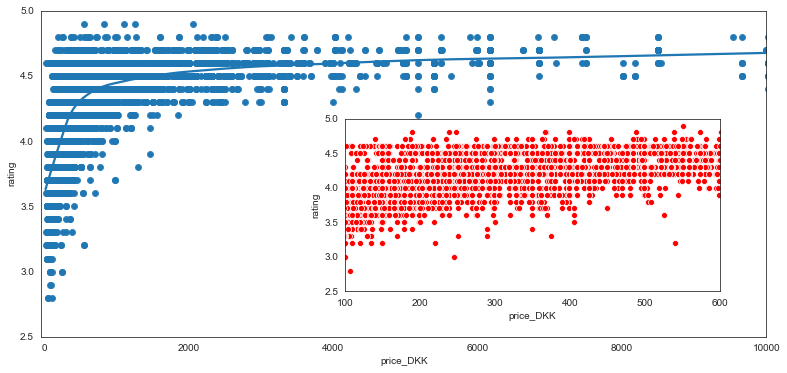

In [186]:
# Create placeholder for our plot:
fig,ax = plt.subplots(1, figsize=(13,6))
ax.set_xlim([-50,10000]), ax.set_ylim([2.5,5])

# Create scatterplot:
price_distribution = sns.scatterplot(x='price_DKK', y='rating',  data=data)

# Add logistic regression to the plot:
sns.regplot(x='price_DKK', y='rating', data=data, lowess=True, ax=ax)

# Create placeholder for zoomed plot:
ax1 = fig.add_axes([0.45, 0.23, 0.4, 0.4])
ax1.set_xlim([100, 600]),ax1.set_ylim([2.5,5])

sns.scatterplot(x='price_DKK', y='rating', data=data, ax=ax1, color='red')


plt.savefig('Rating vs Price.png')


**Insight:** the scatterplot indicates that the rating of Italian red wines increases as the price gets higher. Notably however, we see that this assumption is not always true as it can be observed that some expensive bottles have a lower rating than bottles that are less expensive. Based on this, price seem to be a relevant variable to consider when predicting ratings.

### 2.2 Distribution of rating based on: year of bottle (Scatterplot)

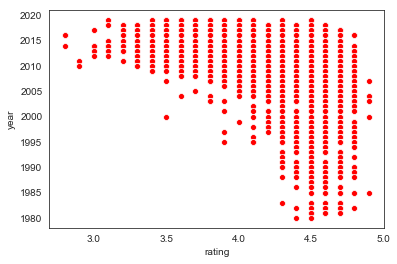

In [196]:
# Create placeholder for our plots:
fig,ax = plt.subplots(1, figsize=(6,4))
fig.subplots_adjust(hspace=.4)    

#Create scatterplot with all years from our dataset:
#price_distribution = sns.scatterplot(x='rating', y='year',  data=df, ax=ax[0])
#price_distribution.set(title='Distribution of rating [1917-2019]')

# We want narrow the distribution and exclude the outlier observations 
# (wines that are older than 1980). To do this we create a subset of our
# dataset and exclude all observations where the year column has a value
# lower than 1980:
after1980 = df.query("year >= 1980").copy()
after1980 = after1980.reset_index(drop=True)

# Create plot of the subset data:
price_distribution2 = sns.scatterplot(x='rating', y='year', color='red', data=after1980, ax=ax)
#price_distribution2.set(title='Distribution of rating [1980-2019]')
plt.savefig('Rating vs Year.png')


**Insight:** The two graphs indicate that there's a correlation between rating and age of Italien red wine. We observe that most oftenly the rating of a wine is higher for aged wines. Interestingly, aged wines (+25 years) almost always receive ratings above 4. This was expected because of XYZ Based on this insight, age of Italian red wines seem to be a relevant variable to consider when predicting ratings. 

### 2.3 Distribution of rating based on: regions (Boxplot)

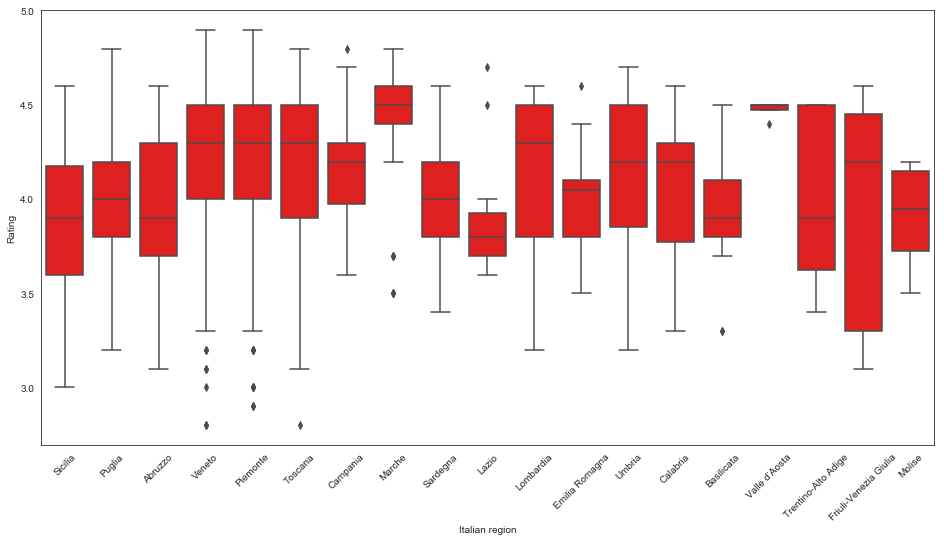

In [190]:
# Creating figures and axis:
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(16,8))
fig.subplots_adjust(hspace=.5)


# Creating boxplots for regions:
region_plot = sns.boxplot(data=df, 
                          x='region', 
                          y='rating',
                          color='red',
                         )
region_plot.set_xticklabels(region_plot.get_xticklabels(), rotation=45)

# Set titles and labels for plot:
#ax.set_title('Rating of Italian red wines - by region')
ax.set(xlabel='Italian region', ylabel='Rating')
plt.savefig('Rating vs Region.png')


**Insights:** From the boxplot we observe that distribution of ratings varies accross the different Italian regions. Comment on the graph before zooming in. We narrow our scope of analysis to 5 regions (Lazio, Veneto, Umbria, Piemonte and Marche) in the interest of simplifying our research. 

In [36]:
# From the boxplots presented above we hand-pick 5 regions (Lazio, Veneto, Umbria, Piemonte and Marche) 
# for further exploration.In order to do a simple descriptive analysis we extract the ratings for each 
# region and store this in a new variable called 'result':
lazio = df.loc[df['region'] == 'Lazio']['rating'].reset_index(drop=True)
veneto = df.loc[df['region'] == 'Veneto']['rating'].reset_index(drop=True)
umbria = df.loc[df['region'] == 'Umbria']['rating'].reset_index(drop=True)
piemonte = df.loc[df['region'] == 'Piemonte']['rating'].reset_index(drop=True)
marche = df.loc[df['region'] == 'Marche']['rating'].reset_index(drop=True)

# We use the concat function from the Pandas library to easily store the data for each region in one variable:
result = pd.concat([lazio,veneto, umbria, piemonte, marche], axis=1, keys=['lazio', 'veneto', 'umbria', 'piemonte', 'marche'])

# We use the describe() function to present descriptive statistics about each region:
result.describe()

,lazio,veneto,umbria,piemonte,marche
count,20.000000,1443.000000,71.000000,1961.000000,41.000000
mean,3.870000,4.271102,4.164789,4.252881,4.375610
std,0.284882,0.347175,0.403236,0.317264,0.349128
min,3.600000,2.800000,3.200000,2.900000,3.500000
25%,3.700000,4.000000,3.850000,4.000000,4.400000
50%,3.800000,4.300000,4.200000,4.300000,4.500000
75%,3.925000,4.500000,4.500000,4.500000,4.600000
max,4.700000,4.900000,4.700000,4.900000,4.800000


**Insights:** What we already saw in the first boxplot, red wines from the region Lazio seems to receive the lowest average ratings (3,9967), while red wine from the region Marche receives the highest average ratings (4,3384). Similary, red wines from Marche generally receive higher ratings considering a 1st quartile of 4,20 meaning that 75% of the wines have received a rating above this rating. The same story goes for the veneto and piemonte regions, where 75% of the wines have received a rating higher than 4,0. Despite wines from the region lazio on average are rated lower than the four others, its standard deviation is in fact the lowest of all five regions, while its mimimum and maximum ratings are 3,7 and 4,7 respectively. This story indicates that red wines from Lazio are often similar in rating and above average.

Notably it can be observed from the data that the range in ratings of red wines from the regions Veneto, Umbria and Piemonte is quite wide (e.g. for Venento MIN-VAL = 2.8 while MAX-VAL = 4.9). This would indicate that a high rating of red Italian wine not neccessarily can be explained from its regional origin but is determined by other factors as well.  

### 2.4 Distribution of wine characteristics based on: regions (Barplots)

### Zooming in at taste note characteristics 

Goldstein (2008) has concluded that expensive wines on average are enjoyed more by wine enthusiasts than non wine-enthusiasts (Puckette, 2015). The reason, he claims, is that most cheap wines has residual sugar in them improving the sense of "richness" in the wine, wheras in fine wines all sugar is most oftenly fermented resulting in a more "dry" wine. Based on this, it could be argued that the residual sugar used to improve the flavor of affordable wines can explain why cheap wines tend to rank equally to fine wines. In order to test the validity of this argument, first we need to test whether dry wines in fact are  more expensive than sweet wines. Below barplot on the left indicates that the average bottle price of wines with either a semi-dry or dry characteristic is higher than semi-sweet and sweet characterized wines respectively. Next, to get an indication of how wines are rated (i.e. whether or not they are enjoyable) based on their taste profile, we create another barplot (ref. below plot to the right). From the plot we can observe that wines with a sweet taste-profile on average receive higher ratings than wines with a dry taste-profile. Other things being equal, one could argue that the argument that cheap red Italian wines are rated high because of their content of residual sugar holds true. Nevertheless, taste characeristics seem to be relevant to consider when predicting the rating of Italian red wines. 

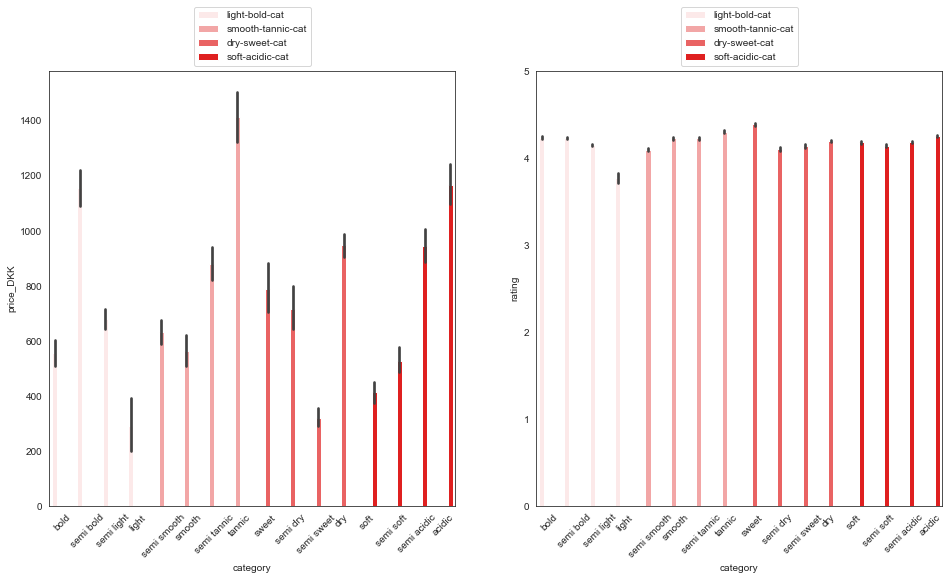

In [184]:
# create subset of our dataframe with price and taste note characteristics, and stack it:
sub3 = df[['price_DKK', 'light-bold-cat', 'smooth-tannic-cat', 'dry-sweet-cat', 'soft-acidic-cat']].copy()
sub3_long = pd.melt(sub3,id_vars=['price_DKK'], var_name='characteristics', value_name='category')

# create subset of our dataframe with rating and taste note characteristics, and stack it:
sub2 = df[['rating', 'light-bold-cat', 'smooth-tannic-cat', 'dry-sweet-cat', 'soft-acidic-cat']].copy()
sub2_long = pd.melt(sub2,id_vars=['rating'], var_name='characteristics', value_name='category')

# create bar plots:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.barplot(x='category', y='price_DKK', hue='characteristics', color='red', data=sub3_long, ax=ax[0]).set_xticklabels(price_charac.get_xticklabels(), rotation=45) #rotate axis 
sns.barplot(x='category', y='rating',  hue='characteristics', color='red', data=sub2_long, ax=ax[1]).set_xticklabels(price_charac.get_xticklabels(), rotation=45) #rotate axis 

ax[0].legend(bbox_to_anchor=(0.5, 1))
ax[1].legend(bbox_to_anchor=(0.5, 1))
ax[1].set_ylim([0,5])
plt.savefig('Taste Note Characteristics.png')


We calculate the average rating for sweet and dry red Italian wines to see that the actual score is in fact higher for sweet red wines:

In [136]:
sweet = sub2_long.loc[(sub2_long['value'] == 'sweet')]
print('Average rating of wines characterized as "sweet": ', round(sweet['rating'].mean(),2))
dry = sub2_long.loc[(sub2_long['value'] == 'dry')]
print('Average rating of wines characterized as "dry": ', round(dry['rating'].mean(),2))

Average rating of wines characterized as "sweet":  4.39
Average rating of wines characterized as "dry":  4.19


In [38]:
# We want to investigate how wine characteristics differ based on Italian regions. 
# First we create a subset of our initial dataframe with regions and characteristics:
subset = df[['region', 'light-bold', 'smooth-tannic', 'dry-sweet', 'soft-acidic']].copy()
display(subset)

,region,light-bold,smooth-tannic,dry-sweet,soft-acidic
0,Sicilia,0.744740,0.330456,0.442528,0.210002
28,Puglia,0.825000,0.279180,0.290822,0.183596
21,Abruzzo,0.698018,0.355739,0.260252,0.278428
22,Sicilia,0.825000,0.333765,0.254032,0.195008
23,Abruzzo,0.698169,0.355909,0.259962,0.278288
...,...,...,...,...,...
7890,Puglia,0.825000,0.348248,0.315641,0.144872
7891,Puglia,0.653592,0.278403,0.497206,0.111184
7892,Toscana,0.374190,0.484859,0.054366,0.584472
7893,Puglia,0.656680,0.186571,0.425289,0.071690


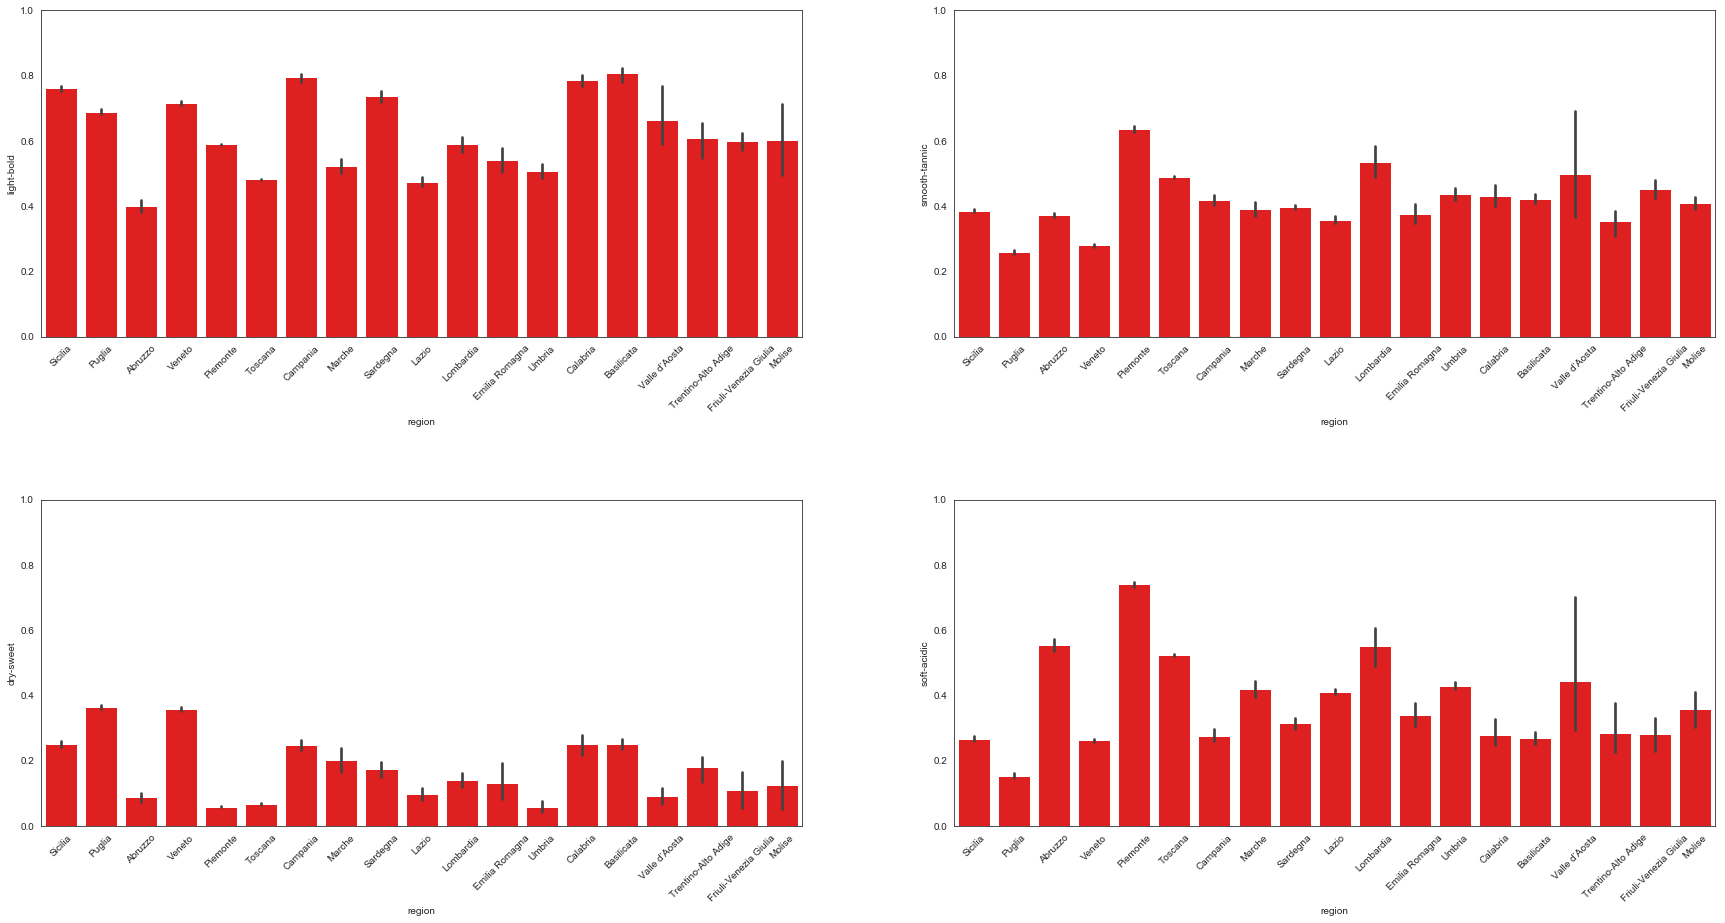

In [185]:
# Next we plot the data in bar plots for each wine charactheristic:
# Create figure and axis and ensure proper spacing and axis setting:
sns.set_style(style='white')
fig, ax = plt.subplots(2, 2, figsize=(30,15))
fig.subplots_adjust(hspace=.5)    
ax[0][0].set_ylim([0,1])
ax[0][1].set_ylim([0,1])
ax[1][0].set_ylim([0,1])
ax[1][1].set_ylim([0,1])

# Create a barplot for each characteristic:
lightbold = sns.barplot(x='region', y='light-bold', color='red', data=subset, ax=ax[0][0]) 
lightbold.set_xticklabels(lightbold.get_xticklabels(), rotation=45)

smootthtannic = sns.barplot(x='region', y='smooth-tannic', color='red', data=subset, ax=ax[0][1]) 
smootthtannic.set_xticklabels(smootthtannic.get_xticklabels(), rotation=45)

drysweet = sns.barplot(x='region', y='dry-sweet', color='red', data=subset, ax=ax[1][0]) 
drysweet.set_xticklabels(drysweet.get_xticklabels(), rotation=45)

softacidic = sns.barplot(x='region', y='soft-acidic', color='red', data=subset, ax=ax[1][1]) 
softacidic.set_xticklabels(softacidic.get_xticklabels(), rotation=45)
plt.savefig('Regional Characteristics.png')


First of all it can be observed that the wine characteristics differ accros Italian wine regions. 

We see that red wines from the region Abruzzo are on average more light than bold, more dry than sweet and more acidic than soft.

Looking at the same previous five regions as before, the following observations can be made:

1. **Lazio:** 
    * Light - bold: average characteristic is more light than bold.
    * Smooth - tannic: average characteristic is more smooth than tannic.
    * Dry - sweet: average characteristic is mostly dry than sweet.
    * Soft - accidic: average characteristic is slightly more soft than accidic.
2. **Veneto:**
    * Light - bold: average characteristic is slightly more bold than light.
    * Smooth - tannic: average characteristic is more smooth than tannic.
    * Dry - sweet: average characteristic is more dry than sweet.
    * Soft - accidic: average characteristic is more soft than accidic.
3. **Umbria:**
    * Light - bold: average characteristic is neither more bold nor light.
    * Smooth - tannic: average characteristic is slightly more smooth than tannic.
    * Dry - sweet: average characteristic is mostly dry than sweet.
    * Soft - accidic: average characteristic is neither more soft nor accidic.    
4. **Piemonte:**
    * Light - bold: average characteristic is neither more bold nor light.
    * Smooth - tannic: average characteristic is neither more smooth nor tannic.
    * Dry - sweet: average characteristic is mostly dry than sweet.
    * Soft - accidic: average characteristic is more accidic than soft.
5. **Marche:**
    * Light - bold: average characteristic is neither more bold nor light.
    * Smooth - tannic: average characteristic is slightly more smooth than tannic.
    * Dry - sweet: average characteristic is mostly dry than sweet.
    * Soft - accidic: average characteristic is more soft than accidic.

# Section 4: Modelling

### Exploring our Data

In Section 2 we cleaned our data and it is now ready to preprocess in order to use it for modelling. The cleaned data looks like the following: 

In [158]:
df_cleaned = pd.read_csv('merged_data.csv', index_col=0)
print('No. of rows and columns:', df_cleaned.shape)
df_cleaned.head()

No. of rows and columns: (7895, 19)


,name,rating,sub_region,year,price_DKK,total_ratings,total_reviews,light-bold,smooth-tannic,dry-sweet,soft-acidic,winery,light-bold-cat,smooth-tannic-cat,dry-sweet-cat,soft-acidic-cat,region,cardinal_1,cardinal_2
0,Passivento Rosso,3.6,Terre Siciliane,2019,93.17,96,1103,0.744740,0.330456,0.442528,0.210002,Barone Montalto,bold,semi smooth,sweet,soft,Sicilia,South,South
1,Pillastro Primitivo Puglia,4.0,Puglia,2019,69.00,823,2072,0.654435,0.154071,0.387081,0.066322,Cantine due Palme,semi bold,smooth,semi sweet,soft,Puglia,East,South-east
2,Fantini Sangiovese Terre di Chieti,3.6,Terre di Chieti,2019,84.17,70,1001,0.424077,0.328759,0.065716,0.403993,Farnese,semi light,semi smooth,dry,semi soft,Abruzzo,East,East
3,Appassite Negroamaro - Primitivo,4.0,Puglia,2019,89.17,102,800,0.825000,0.334615,0.349416,0.184099,Luna Argenta,bold,semi smooth,semi sweet,soft,Puglia,East,South-east
4,Passivento Rosso,3.6,Terre Siciliane,2019,93.17,97,1103,0.744727,0.330469,0.442570,0.210016,Barone Montalto,bold,semi smooth,sweet,soft,Sicilia,South,South


### Converting Columns into Dummy Variables

As we have some categorical variables in our dataset, we want to turn these into dummy variables containing binary values 0 or 1. 

In [165]:
dummies = pd.get_dummies(df_cleaned, columns=['region'], drop_first=True) # Using drop_first to avoid The Dummy Variable Trap
df_dummies = pd.concat([df_cleaned, dummies], axis=1)
df_dummies.drop(['name', 'sub_region', 'region', 'total_ratings', 'total_reviews', 'winery', 'light-bold-cat', 
                 'smooth-tannic-cat', 'dry-sweet-cat', 'soft-acidic-cat', 'cardinal_1', 'cardinal_2'], 
                 inplace=True, axis=1)
df_dummies = df_dummies.iloc[:, 7:] # Drop duplicated columns
df_dummies.head()

,rating,year,price_DKK,light-bold,smooth-tannic,dry-sweet,soft-acidic,region_Basilicata,region_Calabria,region_Campania,...,region_Molise,region_Piemonte,region_Puglia,region_Sardegna,region_Sicilia,region_Toscana,region_Trentino-Alto Adige,region_Umbria,region_Valle d’Aosta,region_Veneto
0,3.6,2019,93.17,0.744740,0.330456,0.442528,0.210002,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,4.0,2019,69.00,0.654435,0.154071,0.387081,0.066322,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3.6,2019,84.17,0.424077,0.328759,0.065716,0.403993,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2019,89.17,0.825000,0.334615,0.349416,0.184099,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,3.6,2019,93.17,0.744727,0.330469,0.442570,0.210016,0,0,0,...,0,0,0,0,1,0,0,0,0,0


We now have a dataset containing only numeric data although we have included the categorical data, which is great. We see that the region 'Abruzzo' was made the reference for the dummy variables. 

### Statistical Information

To get started we run a simple description function to get a sense of the statistic information of the dataset: 

In [166]:
df_dummies.describe()

,rating,year,price_DKK,light-bold,smooth-tannic,dry-sweet,soft-acidic,region_Basilicata,region_Calabria,region_Campania,...,region_Molise,region_Piemonte,region_Puglia,region_Sardegna,region_Sicilia,region_Toscana,region_Trentino-Alto Adige,region_Umbria,region_Valle d’Aosta,region_Veneto
count,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,...,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000
mean,4.194820,2010.545028,840.799951,0.585282,0.462164,0.152078,0.486437,0.003927,0.003040,0.010133,...,0.001267,0.248385,0.068904,0.011653,0.036732,0.383281,0.001267,0.008993,0.000507,0.182774
std,0.358069,6.929609,1438.943777,0.133882,0.182015,0.153446,0.224509,0.062543,0.055055,0.100158,...,0.035569,0.432104,0.253307,0.107325,0.188115,0.486217,0.035569,0.094410,0.022505,0.386506
min,2.800000,1917.000000,11.750000,0.231590,0.085450,0.000000,0.008667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.900000,2008.000000,159.975000,0.474412,0.340428,0.040919,0.255695,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.300000,2012.000000,375.000000,0.588094,0.419206,0.084284,0.474183,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.500000,2015.000000,826.080000,0.646981,0.584629,0.231508,0.628518,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,4.900000,2019.000000,23050.680000,0.825000,0.825000,0.586491,0.825000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In the above table we see that we have a total of XXXX rows in the dataset and hence XXXX observations. We start by looking at one column at a time. 

In the '*rating*' column we see that the mean rating is ~4.16 with a standard deviation of ~0.38. This is a fairly high average rating. We also see that the 1st quantile is 3.9 and we can conclude that most wines in the Vivino.com network has a high rating. 

For the '*year*' column we see that the years of the wine is spread from 1917 up until 2019. However, as the mean year is around 2011, we might have to check whether there are som outliers that a worth removing from our dataset before we begin modelling. 

In the '*price, kr.*' column we inspect the prices of the wines. Here we see that the prices span from just 11 kr. to 11.500. As the mean is ~466 kr. and the standard deviation is ~821, the minimum value seems resonible, but the maximum value of 11.500 kr. seems like an outlier and we will have to check whether some of these high prices should be removed. 

For the next four columns with the taste characteristics we see that all values span from 0% to 82.5%. This was expected as the numbers represent percentages, however there seems to be a static upper cap on the maximum values. Inspecting the Vivino.com site we see that it looks like there is indeed a maximum cap of how high the percentages can get. 

The rest of the columns are our region dummy variables and hence are binary values. As such, these descriptive measures are not of our interest. 

### Inspecting Correlations

Next we examine the correlation between the variables in order to get a better understanding of the relationships between them. We check to see which features are more correlated with the target variable as the model will producere a more accurate result if we pass significant features to the model.

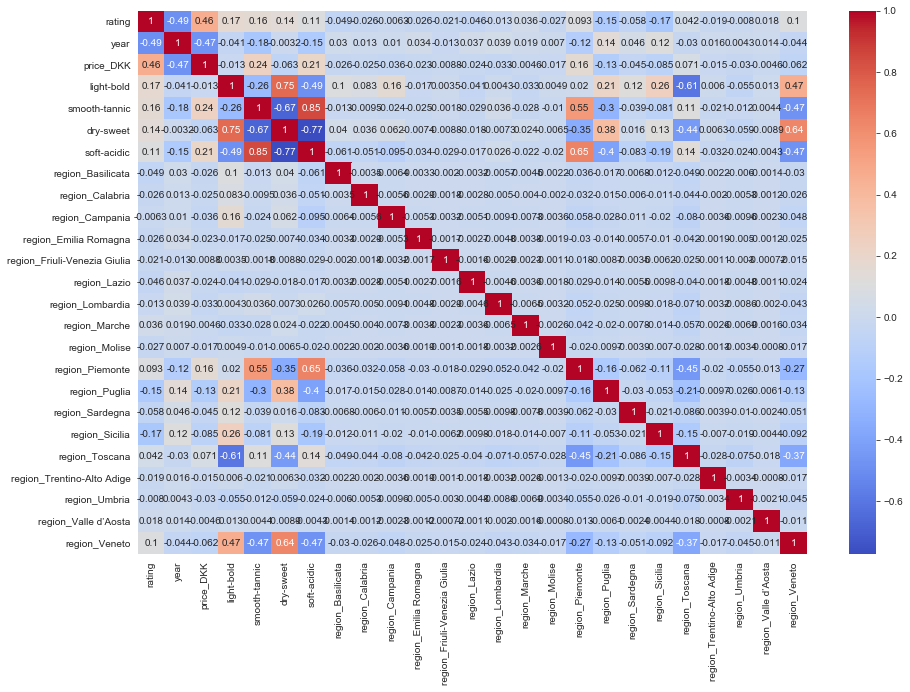

In [167]:
plt.subplots(figsize=(15, 10))
sns.heatmap(df_dummies.corr(), annot=True, cmap='coolwarm')

We see that some features are much more correlated with the target variable than others. Especially the '*year*' and '*price, kr.*' columns are highly correlated with the '*rating*' variable and are therefore important features to include in the model. 

If we look at the correlations between the input variables, we see that there are examples of relationships with high correlations. The highest of these is the correlation between '*soft-acidic*' and '*smooth-tannic*'. Intuitively, this makes sense as a higher acidity often gives a more tannic wine. 

These correlation values might be interesting to look at when possibly reducing the number of features in the model. 

### Detecting Outliers

In order to detect possible outliers in our dataset, we start by making boxplots of the different variables in order to get a better insight of the distribution of the values in the columns. For this we exclude our dummy variables. 

Text(0.5, 0, '')

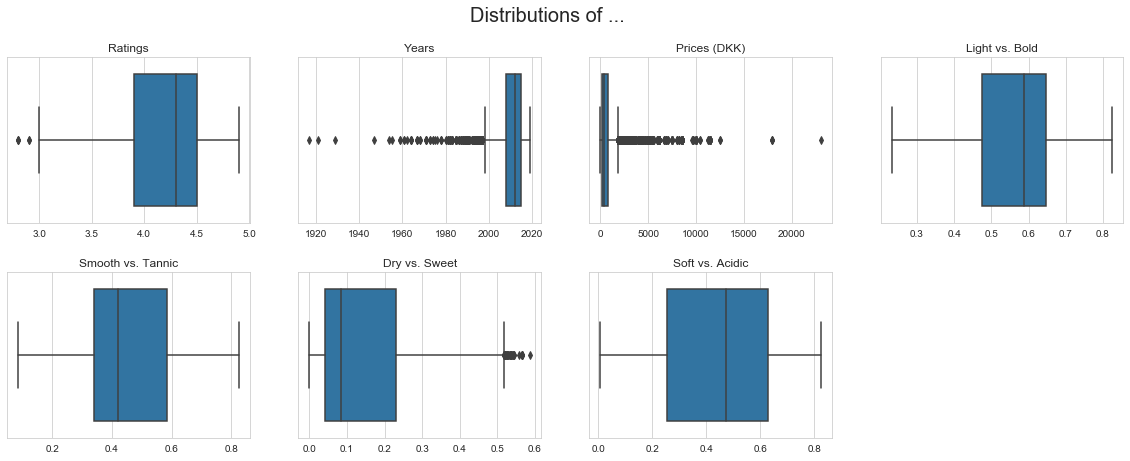

In [168]:
fig, ax = plt.subplots(2, 4, figsize=(20,7))
fig.delaxes(ax[1][3])
fig.subplots_adjust(hspace=0.3) # Adding space between rows
sns.set_style("whitegrid")
fig.suptitle('Distributions of ...', fontsize=20)

bp1 = sns.boxplot(df_dummies['rating'], ax=ax[0][0])
bp2 = sns.boxplot(df_dummies['year'], ax=ax[0][1])
bp3 = sns.boxplot(df_dummies['price_DKK'], ax=ax[0][2])
bp6 = sns.boxplot(df_dummies['light-bold'], ax=ax[0][3])
bp7 = sns.boxplot(df_dummies['smooth-tannic'], ax=ax[1][0])
bp8 = sns.boxplot(df_dummies['dry-sweet'], ax=ax[1][1])
bp9 = sns.boxplot(df_dummies['soft-acidic'], ax=ax[1][2])

ax[0][0].set_title('Ratings')
ax[0][1].set_title('Years')
ax[0][2].set_title('Prices (DKK)')
ax[0][3].set_title('Light vs. Bold')
ax[1][0].set_title('Smooth vs. Tannic')
ax[1][1].set_title('Dry vs. Sweet')
ax[1][2].set_title('Soft vs. Acidic')

ax[0][0].set_xlabel('')
ax[0][1].set_xlabel('')
ax[0][2].set_xlabel('')
ax[0][3].set_xlabel('')
ax[1][0].set_xlabel('')
ax[1][1].set_xlabel('')
ax[1][2].set_xlabel('')

From the above we see that most of the values are evenly spread for the different variables. However, the '*year*' and '*price_DKK*' variables have a lot of outliers in the left and right part of the boxplots respectively. We see that most of the wines are produced between 1995 and 2019 at a price levet from 0 kr. to ~2000 kr. The values outside these limits seem to be outliers. 

In order to streamline the data and get the best performance of the machine learning model, we want to remove these outliers. At first we examine how many outliers we have in order to check whether it is wise to remove them. 

In [169]:
print('There are', len(df_dummies), 'observations in total.')
print()
print('There are', np.count_nonzero(df_dummies['year']<1995), 'observations before year 1995, which corresponds to',
     round(np.count_nonzero(df_dummies['year']<1995)/len(df_dummies)*100,1), '% of the data.')
print()
print('There are', np.count_nonzero(df_dummies['price_DKK']>2000), 'observations with a price above 2000 kr., which corresponds to',
     round(np.count_nonzero(df_dummies['price_DKK']>2000)/len(df_dummies)*100,1), '% of the data.')
print()
print('There are', np.count_nonzero(np.logical_or(df_dummies['year']<1995, df_dummies['price_DKK']>2000)), 'observations before year 1995 OR with a price above 2000 kr., which corresponds to',
     round(np.count_nonzero(np.logical_or(df_dummies['year']<1995, df_dummies['price_DKK']>2000))/len(df_dummies)*100,1), '% of the data.')

There are 7895 observations in total.

There are 205 observations before year 1995, which corresponds to 2.6 % of the data.

There are 795 observations with a price above 2000 kr., which corresponds to 10.1 % of the data.

There are 892 observations before year 1995 OR with a price above 2000 kr., which corresponds to 11.3 % of the data.


From the above we see that removing the outliers in columns '*year*' and '*price, kr.*' will only remove 8.6% of our observations and as so we remove them. We now use the *z*-score in order to correctly find and remove the true outliers. To find the *z*-scores we take each observation value, subtract the mean and divide this by the standard deviation. As such, the score tells us how many standard deviations the observation value is from the mean. Mathematically the *z*-score is defined as follows: 
\begin{align}
z = \frac{X-\mu}{\sigma} \\
\end{align}

We calculate the *z*-score for each observation and characterise an observation as an outlier if the *z*-score of that observation is greater than 3 or less than -3. Using the number 3 as threshold is based on the empirical rule. 

In [170]:
# Outliers in the 'price, kr.' column
threshold = 3
outliers_price = [] 
mean_price = df_dummies['price_DKK'].values.mean()
std_price = df_dummies['price_DKK'].values.std() 
for x in df_dummies['price_DKK'].values:
    z = (x-mean_price)/std_price
    if abs(z) > threshold: 
        outliers_price.append(x) 
outliers_price = sorted(outliers_price)
print('The outliers in the "price_DKK" column are:', outliers_price, '\nNumber of outliers:', 
      len(outliers_price), '\nPart of dataset:', round(len(outliers_price)/len(df_dummies)*100, 1), '%')

The outliers in the "price_DKK" column are: [5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5165.2, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5396.48, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5495.0, 5500.0, 5623.66, 5888.67, 5920.92, 5981.12, 5981.12, 5993.71, 5993.71, 5995.0, 5995.0, 5995.0, 5995.0, 5995.0, 6013.22, 6013.22, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6167.41, 6629.22, 6629.22, 6629.22, 6828.09, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 6852.67, 7058.25, 7080.94, 744

In [171]:
# Outliers in the 'year' column
threshold = 3
outliers_year = [] 
mean_year = df_dummies['year'].values.mean()
std_year = df_dummies['year'].values.std() 
for x in df_dummies['year'].values:
    z = (x-mean_year)/std_year
    if abs(z) > threshold: 
        outliers_year.append(x) 
outliers_year = sorted(outliers_year)
print('The outliers in the "year" column are:', outliers_year, '\nNumber of outliers:', len(outliers_year),
     '\nPart of dataset:', round(len(outliers_year)/len(df_dummies)*100, 1), '%')

The outliers in the "year" column are: [1917, 1921, 1929, 1947, 1954, 1955, 1959, 1959, 1961, 1961, 1962, 1964, 1964, 1964, 1964, 1967, 1967, 1967, 1968, 1968, 1971, 1971, 1971, 1971, 1973, 1973, 1974, 1974, 1975, 1976, 1978, 1978, 1978, 1980, 1980, 1981, 1981, 1981, 1981, 1981, 1981, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1982, 1983, 1983, 1983, 1983, 1983, 1983, 1983, 1983, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1985, 1986, 1986, 1986, 1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1987, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1988, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989, 1989] 
Number of outliers: 113 
Part of dataset: 1.4 %


As we see from the above calculations, we were a bit harsh on the range of outliers as we now "only" have 202 and 113 outliers for price and year respectively. We will now remove these outliers from out dataset. 

In [172]:
df_ready = df_dummies.copy()
df_ready = df_ready[~df_ready['price_DKK'].isin(outliers_price)] # Removing price outliers
df_ready = df_ready[~df_ready['year'].isin(outliers_year)] # Removing year outliers

In [173]:
print('Year:', '\n', '\nMean before:', df_dummies['year'].mean(), '\nMean after:', df_ready['year'].mean(),
      '\nDifference:', round((df_ready['year'].mean()-df_dummies['year'].mean())/df_dummies['year'].mean()*100,3), '%\n',
      '\nStd. before:', df_dummies['year'].std(), '\nStd. after:', df_ready['year'].std(), '\nDifference:',
      round((df_ready['year'].std()-df_dummies['year'].std())/df_dummies['year'].std()*100,3), '%\n')
print()
print('Price:', '\n', '\nMean before:', df_dummies['price_DKK'].mean(), '\nMean after:', df_ready['price_DKK'].mean(),
      '\nDifference:', round((df_ready['price_DKK'].mean()-df_dummies['price_DKK'].mean())/df_dummies['price_DKK'].mean()*100,3), '%\n',
      '\nStd. before:', df_dummies['price_DKK'].std(), '\nStd. after:', df_ready['price_DKK'].std(), '\nDifference:',
      round((df_ready['price_DKK'].std()-df_dummies['price_DKK'].std())/df_dummies['price_DKK'].std()*100,3), '%\n')

Year: 
 
Mean before: 2010.54502849905 
Mean after: 2011.224934383202 
Difference: 0.034 %
 
Std. before: 6.929608636214551 
Std. after: 5.372835947603216 
Difference: -22.466 %


Price: 
 
Mean before: 840.7999506016528 
Mean after: 651.0448333333358 
Difference: -22.568 %
 
Std. before: 1438.9437772554888 
Std. after: 807.180452933326 
Difference: -43.905 %



As we can see from the above, the means of the '*year*' column hasn't changed much. This is probably due to the fact that the numerical values of the years aren't that far away from each other. However, removing the outliers decreases the standard deviation with 22%. 

Removing the outliers for the '*price, kr.*' column decreases the mean with 23% due to the high prices being removed. But again we see that the standard deviation has improved a lot as it has decreased by 44%. 

We conclude that removing those few outliers (a decrease in the number of rows of 3.5%) improves our data quality and possibly affect the performance of our machine learning model positively. 

To take a look at this new (and hopefully improved) data, we check the difference in the correlations between the target variable and the input variables. 

In [174]:
correlation_overview = pd.DataFrame({'before':df_dummies.corrwith(df_dummies['rating']), 
                                     'after':df_ready.corrwith(df_ready['rating']), 
                                    '%-diff':round((df_ready.corrwith(df_ready['rating'])-df_dummies.corrwith(df_dummies['rating']))/df_dummies.corrwith(df_dummies['rating']), 2)})
correlation_overview


,before,after,%-diff
rating,1.000000,1.000000,0.00
year,-0.494027,-0.526604,0.07
price_DKK,0.463180,0.562766,0.22
light-bold,0.173684,0.180481,0.04
smooth-tannic,0.158887,0.144250,-0.09
dry-sweet,0.141192,0.150257,0.06
soft-acidic,0.106363,0.092145,-0.13
region_Basilicata,-0.049436,-0.048126,-0.03
region_Calabria,-0.026190,-0.024541,-0.06
region_Campania,-0.006307,-0.002089,-0.67


We see that the two highly correlated variables '*year*' and '*price_DKK*' are now even more correlated with the target variable. The remaining input variables are either approximately the same or have decreased. In most cases the decrease has in fact decreased the correlation as the correlations approaches zero. 

### Applying Supervised Machine Learning

In [194]:
# Splitting the data in target and data (y and x)
y = df_ready.rating.to_numpy()
X = df_ready.drop(['rating'],axis=1) 

In [195]:
# Split X, y into development and test data 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=.3, random_state=1)    

In [196]:
# Defining a function to calculate RMSE 
def rmse(y_pred, y_true):
    return mse(y_pred, y_true, squared=False)

#### Linear Regression

For the Linear Regression model we don't have any hyperparameters to optimise, and so we use the training and development sets to decide whether or not to add polynomials. We split the development data into training and validation sets in a 50%/50% split. 

We know from prior knowledge that the usual peak of performance occurs at either 2nd or 3rd degree. Due to attempts to increase the degree even further where we lack in computational power, we have decided to only test the different models up to and including 4th degree. 

In [214]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.5, random_state=1)

In [221]:
# Linear Regression with Polynomials
lambdas =  np.logspace(-4, 4, 20)

lr_mse_train = []
lr_rmse_train = []
lr_mse_val = []
lr_rmse_val = []
lr_coefs_val = []
lr_inter_val = []

for i in tqdm(range(1, 5)): 
    pipe_lr_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),
                                StandardScaler(),
                                LinearRegression())
    pipe_lr_pol.fit(X_train, y_train)
    
    lr_mse_train.append(mse(pipe_lr_pol.predict(X_train),y_train))
    lr_rmse_train.append(rmse(pipe_lr_pol.predict(X_train),y_train))
    lr_mse_val.append(mse(pipe_lr_pol.predict(X_val),y_val))
    lr_rmse_val.append(rmse(pipe_lr_pol.predict(X_val),y_val))
    lr_coefs.append(pipe_lr.steps[1][1].coef_)
    lr_inter.append(pipe_lr.steps[1][1].intercept_)
    

In [229]:
lr_overview = pd.DataFrame({'MSE train':lr_mse_train, 'RMSE train':lr_rmse_train, 'MSE val':lr_mse_val, 'RMSE val':lr_rmse_val}
                           , index=range(1,5))
lr_overview

,MSE train,RMSE train,MSE val,RMSE val
1,0.056454,0.237601,6.410091e-02,2.531816e-01
2,0.037398,0.193385,5.607857e+24,2.368091e+12
3,0.030437,0.174461,9.340926e+24,3.056293e+12
4,0.016984,0.130322,1.378094e+19,3.712269e+09


The index represents each degree. From the above results we see that the MSE and RMSE for the training data decreases with the number of degrees. Adding polynomials hence increases the accuracy in which the fit describes the traning data. However, the MSE and RMSE for the validation data drastically increases when we add more polynomials and so the fit doesn't fit new data very well. This is a classic example of overfitting. 
We conclude that adding polynomials to an OLS model does not improve the accuracy of the fit and that the simple linear regression is the best model of this type.

#### Ridge Regression

When attempting to optimise a Ridge Regression on our data and find the optimal degree and hyperparameter, we tried using GridSearchCV to automate the process. However as you can see below, there were too many combinations of hyperparameter values and degree values and it took more than 12 hours to run the search from 1st to 4th degree. Also, we can see from the first four results below that the MSE/RMSE did indeed increase from the 3rd to the 4th degree. 

In [207]:
# Ridge Regression with polynomials
lambdas =  np.logspace(-4, 4, 20)

ridge_mse = []
ridge_rmse = []

for i in tqdm(range(1, 5)): 
    pipe_ridge_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),                           
                                   StandardScaler(),
                                   Ridge(random_state=1))

    ridge_pol_regr = GridSearchCV(estimator=pipe_ridge_pol, 
                                  param_grid=[{'ridge__alpha':lambdas}], 
                                  scoring='neg_mean_squared_error', 
                                  cv=10, 
                                  n_jobs=-1)
    ridge_pol_regr.fit(X_dev, y_dev)
    
    ridge_mse.append(ridge_pol_regr.best_score_*-1)
    ridge_rmse.append(np.sqrt(ridge_pol_regr.best_score_*-1))
    
    print(f'Degree={i}', '\nBest parameters:', ridge_pol_regr.best_params_, 
          '\nBest score (MSE):', ridge_pol_regr.best_score_*-1, 
          '\nBest score (RMSE):', np.sqrt(ridge_pol_regr.best_score_*-1))
    print()
    

Degree=1 
Best parameters: {'ridge__alpha': 11.288378916846883} 
Best score (MSE): 0.06058823334785286 
Best score (RMSE): 0.24614677196309698

Degree=2 
Best parameters: {'ridge__alpha': 11.288378916846883} 
Best score (MSE): 0.04780514382959335 
Best score (RMSE): 0.21864387443876251

Degree=3 
Best parameters: {'ridge__alpha': 206.913808111479} 
Best score (MSE): 0.04777620551587649 
Best score (RMSE): 0.21857768759842916

Degree=4 
Best parameters: {'ridge__alpha': 1438.44988828766} 
Best score (MSE): 0.05184769215433258 
Best score (RMSE): 0.22770088307763012



KeyboardInterrupt: 

As such, we try to use RandomizedSearchCV instead, which hopefully doesn't take as long time to finish. 

We optimise the hyperparamter lambda using a pipeline to streamline the preprocessing stage where we scale data with polynomials with degrees from 1 to 4, standard scale data and implement Ridge regression. Then we use RandomizedSearchCV in order to find the optimal hyperparameter using the Randomized Search method, cross validation and k=10 folding. We optimise using the MSE as scoring (stated as negative as it maximises the scoring) and use a 10-fold cross validation. In order to use all processors to run the jobs, we set n_jobs to -1. 

Then we fit this on the development data and find the best score (MSE as well as RMSE) and the best parameter (lambda).

In [236]:
# Ridge Regression with Polynomials (Randomized Search)
lambdas =  np.logspace(-4, 4, 20)

ridge_mse = []
ridge_rmse = []
ridge_best_param = []

for i in tqdm(range(1, 5)): 
    pipe_ridge_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),                           
                                   StandardScaler(),
                                   Ridge(random_state=1))

    ridge_pol_regr_rand = RandomizedSearchCV(estimator=pipe_ridge_pol, 
                                             param_distributions=[{'ridge__alpha':lambdas}], 
                                             scoring='neg_mean_squared_error', 
                                             cv=10, 
                                             n_jobs=-1)
    ridge_pol_regr_rand.fit(X_dev, y_dev)
    
    ridge_mse.append(ridge_pol_regr_rand.best_score_*-1)
    ridge_rmse.append(np.sqrt(ridge_pol_regr_rand.best_score_*-1))
    ridge_best_param.append(ridge_pol_regr_rand.best_params_)


Below we summarize which hyperparameter value is best for each degree as well as the MSE and RMSE:

In [278]:
ridge_overview = pd.DataFrame({'optimal_lambda': ridge_best_param, 'MSE':ridge_mse, 'RMSE':ridge_rmse}
                           , index=range(1,5))
ridge_overview

,optimal_lambda,MSE,RMSE
1,{'ridge__alpha': 11.288378916846883},0.060588,0.246147
2,{'ridge__alpha': 11.288378916846883},0.047805,0.218644
3,{'ridge__alpha': 206.913808111479},0.047776,0.218578
4,{'ridge__alpha': 10000.0},0.055571,0.235736


We can see from these results that the optimal lambda value for the 4th degree reaches the maximum value. As such, we run the iterations again and increase the lambda range. 

In [298]:
# Ridge Regression with Polynomials (Randomized Search)
lambdas =  np.logspace(-4, 6, 20)

ridge_mse = []
ridge_rmse = []
ridge_best_param = []

for i in tqdm(range(1, 5)): 
    pipe_ridge_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),                           
                                   StandardScaler(),
                                   Ridge(random_state=1))

    ridge_pol_regr_rand = RandomizedSearchCV(estimator=pipe_ridge_pol, 
                                             param_distributions=[{'ridge__alpha':lambdas}], 
                                             scoring='neg_mean_squared_error', 
                                             cv=10, 
                                             n_jobs=-1)
    ridge_pol_regr_rand.fit(X_dev, y_dev)
    
    ridge_mse.append(ridge_pol_regr_rand.best_score_*-1)
    ridge_rmse.append(np.sqrt(ridge_pol_regr_rand.best_score_*-1))
    ridge_best_param.append(ridge_pol_regr_rand.best_params_)


In [325]:
ridge_overview = pd.DataFrame({'optimal_lambda': ridge_best_param, 'MSE':ridge_mse, 'RMSE':ridge_rmse}
                           , index=range(1,5))
ridge_overview['optimal_lambda'] = [i['ridge__alpha'] for i in ridge_overview.optimal_lambda]
ridge_overview

,optimal_lambda,MSE,RMSE
1,18.329807,0.060588,0.246145
2,5.455595,0.047927,0.218923
3,206.913808,0.047776,0.218578
4,695.192796,0.052950,0.230108


We see from the above that the minimum MSE/RMSE is reached at the 3rd degree with an optimal lambda value at 206.9138. We save this optimal value as a variable.

In [381]:
hyperparam_perform = pd.Series(ridge_overview['MSE'].values.tolist(), index=ridge_overview['optimal_lambda'].values.tolist())
optimal_ridge = hyperparam_perform.nsmallest(1)
print('Optimal lambda:', optimal_ridge.index[0])
print('Validation MSE: %.6f' % optimal_ridge.values[0])

Optimal lambda: 206.913808111479
Validation MSE: 0.047776


#### Lasso Regression

The process for the Lasso Regression is very much like the process for the Ridge Regression. As we need for the model to converge, we up the number of maximum iterations to 1,000,000.

Then we fit this on the development data and find the best score (MSE as well as RMSE) and the best parameter (lambda).

In [289]:
# Lasso Regression with Polynomials (Randomized Search CV)
lambdas =  np.logspace(-4, 4, 20)

lasso_mse = []
lasso_rmse = []
lasso_best_param = []

for i in tqdm(range(1, 5)): 
    pipe_lasso_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),                           
                                   StandardScaler(),
                                   Lasso(random_state=1, max_iter=1000000))

    lasso_pol_regr_rand = RandomizedSearchCV(estimator=pipe_lasso_pol, 
                                             param_distributions=[{'lasso__alpha':lambdas}], 
                                             scoring='neg_mean_squared_error', 
                                             cv=10, 
                                             n_jobs=-1)
    lasso_pol_regr_rand.fit(X_dev, y_dev)
    
    lasso_mse.append(lasso_pol_regr_rand.best_score_*-1)
    lasso_rmse.append(np.sqrt(lasso_pol_regr_rand.best_score_*-1))
    lasso_best_param.append(lasso_pol_regr_rand.best_params_)
    

KeyboardInterrupt: 

As you can see from the above, we chose to stop the iterations after approximately 17 hours. We don't have the computer power and/or the time to run the optimisation for all four degrees and so we settle for the first three.

Below we summarize which hyperparameter value is best for each degree as well as the MSE and RMSE:

In [328]:
lasso_overview = pd.DataFrame({'optimal_lambda': lasso_best_param, 'MSE':lasso_mse, 'RMSE':lasso_rmse}
                           , index=range(1,4))
lasso_overview['optimal_lambda'] = [i['lasso__alpha'] for i in lasso_overview.optimal_lambda]
lasso_overview

,optimal_lambda,MSE,RMSE
1,0.000264,0.060583,0.246136
2,0.001833,0.048334,0.219849
3,0.004833,0.049373,0.222200


We see from the above that the minimum MSE/RMSE is reached at the 2nd degree with an optimal lambda value at 0.00183. We save this optimal value as a variable.

In [380]:
hyperparam_perform = pd.Series(lasso_overview['MSE'].values.tolist(), index=lasso_overview['optimal_lambda'].values.tolist())
optimal_lasso = hyperparam_perform.nsmallest(1)
print('Optimal lambda:', optimal_lasso.index[0])
print('Validation MSE: %.6f' % optimal_lasso.values[0])

Optimal lambda: 0.0018329807108324356
Validation MSE: 0.048334


#### ElasticNet Regression

Again, the process for the ElasticNet Regression is very much like the two previous processes. Here we optimise both the lambda value and the L1-ratio. 

Then we fit this on the development data and find the best score (MSE as well as RMSE) and the best parameters.

In [18]:
# Elastic Net Regression with Polynomials (Randomized Grid Search)
lambdas =  np.logspace(-4, 4, 20)

en_mse = []
en_rmse = []
en_best_params = []

for i in tqdm(range(1, 5)):
    pipe_en_pol = make_pipeline(PolynomialFeatures(degree=i, include_bias=True),                           
                                StandardScaler(),
                                ElasticNet(max_iter=1000000))

    en_pol_regr_rand = RandomizedSearchCV(estimator=pipe_en_pol, 
                                     param_distributions={'elasticnet__alpha':lambdas*2,
                                                          'elasticnet__l1_ratio':np.linspace(0,1,10)}, 
                                     scoring='neg_mean_squared_error', 
                                     n_jobs=-1,
                                     iid=False,
                                     cv=10)
    en_pol_regr_rand.fit(X_dev, y_dev)
    
    en_mse.append(en_pol_regr_rand.best_score_*-1)
    en_rmse.append(np.sqrt(en_pol_regr_rand.best_score_*-1))
    en_best_params.append(en_pol_regr_rand.best_params_)
    

/Users/lilly/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/lilly/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/lilly/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.70822731316267, tolerance: 0.06703946831646043
  positive)
/Users/lilly/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
exception calling callback for <Future at 0x1a2238bd90 state=finishe

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

For the ElasticNet as well, we don't have the computer power and/or the time to run the optimisation for all four degrees and so we settle for the first three.

In [333]:
en_overview = pd.DataFrame({'optimal_params': en_best_params, 'MSE':en_mse, 'RMSE':en_rmse}
                           , index=range(1,4))
en_overview['optimal_lambda'] = [i['elasticnet__alpha'] for i in en_overview.optimal_params]
en_overview['optimal_L1_ratio'] = [i['elasticnet__l1_ratio'] for i in en_overview.optimal_params]
en_overview

,optimal_params,MSE,RMSE,optimal_lambda,optimal_L1_ratio
1,"{'elasticnet__l1_ratio': 0.5555555555555556, '...",0.060583,0.246136,0.000527,0.555556
2,"{'elasticnet__l1_ratio': 0.0, 'elasticnet__alp...",0.047933,0.218937,0.009666,0.000000
3,"{'elasticnet__l1_ratio': 0.4444444444444444, '...",0.048241,0.219638,0.001390,0.444444


We see from the above that the minimum MSE/RMSE is reached at the 2nd degree with an optimal lambda value of 0.00967. We also notice that the L1-ratio is equal to 0.0 and as such the penalty for the ElasticNet would be an L2 penalty.

#### Comparing the Models

Now we retrain the models using the optimal hyperparameters and degrees on the entire development set: 

In [389]:
opt_pipe_lr = make_pipeline(StandardScaler(),
                            LinearRegression())
opt_pipe_lr.fit(X_dev,y_dev)


opt_pipe_ridge = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=optimal_ridge.index[0], random_state=1, max_iter=100000))
opt_pipe_ridge.fit(X_dev,y_dev)


opt_pipe_lasso = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=optimal_lasso.index[0], random_state=1, max_iter=100000))
opt_pipe_lasso.fit(X_dev,y_dev)


opt_pipe_en = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), 
                            StandardScaler(),
                            ElasticNet(alpha=en_overview['optimal_lambda'][1]
                                       , l1_ratio=en_overview['optimal_L1_ratio'][1], random_state=1, max_iter=100000))
opt_pipe_en.fit(X_dev,y_dev)
print()

Finally, we test the models on the test set:

In [390]:
models = {'LinReg':opt_pipe_lr, 'Ridge CV':opt_pipe_ridge, 'Lasso CV':opt_pipe_lasso, 'ElasicNet CV':opt_pipe_en}

score_mse = []
score_rmse = []
names = []

for name, model in models.items():
    score_mse.append(round(mse(model.predict(X_test),y_test), 6))
    score_rmse.append(round(np.sqrt(mse(model.predict(X_test),y_test)), 6))
    names.append(name)
    
results = pd.DataFrame({'Model':names, 'MSE':score_mse, 'RMSE':score_rmse})
results

,Model,MSE,RMSE
0,LinReg,0.066822,0.258499
1,Ridge CV,0.051842,0.227689
2,Lasso CV,0.053245,0.230749
3,ElasicNet CV,0.052361,0.228824


We see that when we do the final test on the model using the test set the ridge regression performs the best. Hence, we conclude that this machine learning method fits our data the best.

Lastly we plot our expected ratings as a function of the predicted ratings for each of the models to get an insight to the results:

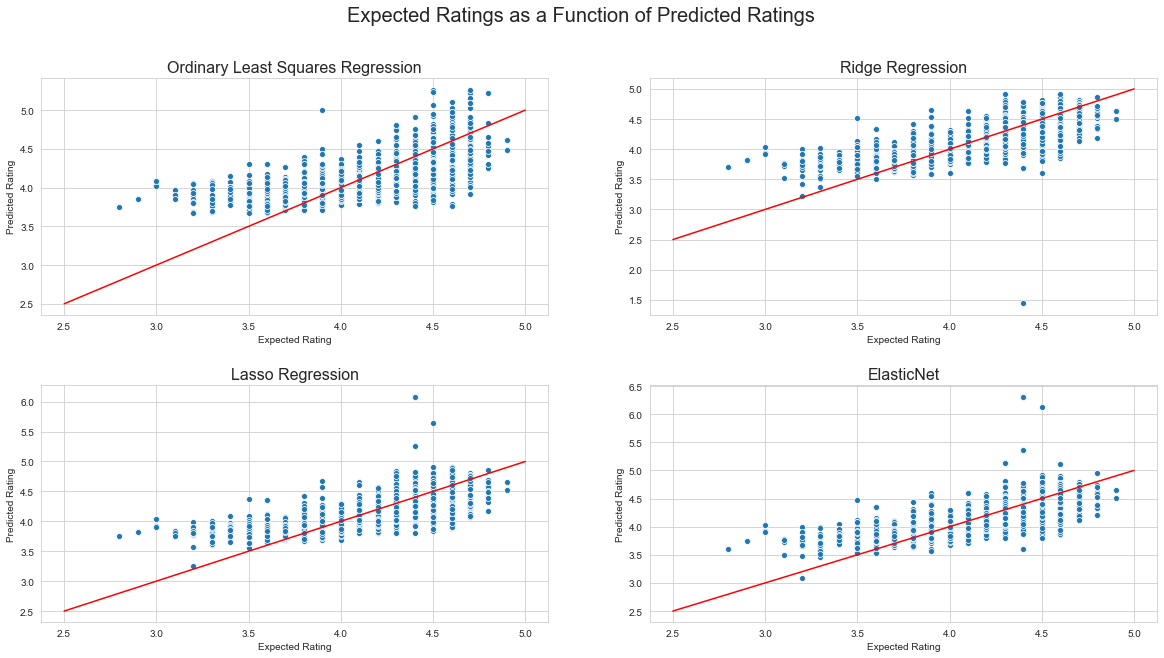

In [535]:
expected = y_test
predicted_lr = opt_pipe_lr.predict(X_test)
predicted_ridge = opt_pipe_ridge.predict(X_test)
predicted_lasso = opt_pipe_lasso.predict(X_test)
predicted_en = opt_pipe_en.predict(X_test)

fig, ax = plt.subplots(2, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.3) # Adding space between rows
sns.set_style("whitegrid")
fig.suptitle('Expected Ratings as a Function of Predicted Ratings', fontsize=20)

plot1 = sns.scatterplot(expected, predicted_lr, ax=ax[0][0])
plot2 = sns.scatterplot(expected, predicted_ridge, ax=ax[0][1])
plot3 = sns.scatterplot(expected, predicted_lasso, ax=ax[1][0])
plot4 = sns.scatterplot(expected, predicted_en, ax=ax[1][1])

ax[0][0].set_title('Ordinary Least Squares Regression', fontsize=16)
ax[0][1].set_title('Ridge Regression', fontsize=16)
ax[1][0].set_title('Lasso Regression', fontsize=16)
ax[1][1].set_title('ElasticNet', fontsize=16)

ax[0][0].set_xlabel('Expected Rating')
ax[0][1].set_xlabel('Expected Rating')
ax[1][0].set_xlabel('Expected Rating')
ax[1][1].set_xlabel('Expected Rating')

ax[0][0].set_ylabel('Predicted Rating')
ax[0][1].set_ylabel('Predicted Rating')
ax[1][0].set_ylabel('Predicted Rating')
ax[1][1].set_ylabel('Predicted Rating')

X_plot = np.linspace(2.5, 5)
Y_plot = np.linspace(2.5, 5)
ax[0][0].plot(X_plot, Y_plot, color='r')
ax[0][1].plot(X_plot, Y_plot, color='r')
ax[1][0].plot(X_plot, Y_plot, color='r')
ax[1][1].plot(X_plot, Y_plot, color='r')

In [536]:
fig.savefig('results.png')